## **Finding Lane Lines on the Road** 
***
In this project, I have used basic functionalities of OpenCV and Python to identify lane lines on the road. 

I have used the following techniques to detect lanes on the provided dataset


`1)RGB to GrayScale Conversion`                               
`2)Canny Edge Detection`                                         
`3)Region of Interest Selection`                                 
`4)Hough Transform Line Detection`

### Imported packages
These are the packages i felt necessay to complete the project

In [14]:
#importing some useful packages
import matplotlib.pyplot as plt 
'''
To plot the images it gives great visualization without having
actually dump the images.
'''
import matplotlib.image as mpimg #To deal with images
import numpy as np # Numerical python to perform operations
import cv2 #Opencv to use computer vision algorithms on our image
import math
import os,glob #File writing and reading operations
from moviepy.editor import VideoFileClip #Video Reading and Writing operation
from IPython.display import HTML #Video Visualization
from collections import deque #Queue operations to track the history of previous frames
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### OpenCV support Functions

In [15]:
def grayscale(Image):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    """
    return cv2.cvtColor(Image, cv2.COLOR_RGB2GRAY)
    
def canny(Image, Sigma):
    """Applies the Canny transform"""
    MedVar = np.median(Image)
    #Tried experimenting on different values of sigma, sigma being 33 percent fits the requirement
    #Determining the lower and upper threshold using the median information of the image.
    Lower = int(max(0, (1.0 - Sigma) * MedVar))
    Upper = int(min(255, (1.0 + Sigma) * MedVar))
    '''
    its better to use the intensity information of the image to determine the thersholds
    rather than using trial and error method.
    '''
    return cv2.Canny(Image, Lower, Upper)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon.
    In this case it is almost like an ROI pyramid.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    #cv2.fillPoly(mask, vertices, ignore_mask_color)
    cv2.fillPoly(mask, np.array([vertices], dtype=np.int32),ignore_mask_color)
    #vertices should be a numpy array of integer points
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    '''
    line drawing function based on the output from hough line transform
    '''
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    return img

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

### Helper Functions

In [16]:
def ImageDisplay(Images,ColorMap=None):
    '''
    for visualizing the image output for all scenarios
    '''
    # // is the floored-division operator in Python
    cols = 2
    rows = (len(Images)+1)//cols
    plt.figure(figsize=(10,11))
    #setting up the layout to display images
    for iterator, Image in enumerate(Images):
        plt.subplot(rows,cols,iterator+1)
        ColorMap = 'gray' if len(Image.shape)==2 else ColorMap
        plt.imshow(Image,cmap=ColorMap)
        plt.xticks([])
        plt.yticks([])
        plt.savefig('Extrapolated_lines.png')
    plt.tight_layout(pad=0,h_pad=0,w_pad=0)
    plt.show()
    
    
def Extrapolating_lines(Lines):
    LeftLines =[]
    LeftLength = []
    RightLines = []
    RightLength = []
    '''
    For each line detected by the hougtransform, finding slope and intercept so that
    it can be used to extrapolate the lines to do lane detection on frames in a video
    '''
    for Line in Lines:
        for x1,y1,x2,y2 in Line:
            if x2==x1:#to avoid divided by zero error
                continue
            slope = (y2-y1)/(x2-x1)
            intercept = y1-slope*x1
            length = np.sqrt((y2-y1)**2 + (x2-x1)**2)
            #slope determines the orientation of the line
            #slope being negative means it is tilted towards left side
            #slope being positive means it is tilted towards Right side
            if slope < 0:
                LeftLines.append((slope,intercept))
                LeftLength.append((length))
            else:
                RightLines.append((slope,intercept))
                RightLength.append((length))
    '''
    finding the average of left and right lanes to determine the extrapolated
    final left and right lane
    '''
    if(len(LeftLength) > 0):
        LeftLane = np.dot(LeftLength,LeftLines)/np.sum(LeftLength)
    else:
        None
        
    if(len(RightLength) > 0):
        RightLane = np.dot(RightLength,RightLines)/np.sum(RightLength)
    else:
        None
    
    return LeftLane,RightLane

def LinePoints(y1,y2,line):
    if line is None:
        return None
    slope, intercept = line
    '''
    using the slope and intercept of a line and known y1 and y2
    which is the predeterminded from the height of the image and ROI
    we can calculate the coordinates neccessary to draw the line
    '''
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1,y1),(x2,y2))

def lane_lines(image, lines):
    '''
    The lines extracted from hough line transform is utilized by the
    function Extrapolating lines to give the final left and right lane
    '''
    left_lane, right_lane = Extrapolating_lines(lines)
    #y1 is the height and starting cordinate for the ROI pyramid
    #y2 is 59% of the original height of the image.
    #y2 is set in such a way just to avoid two lines(left and right) getting intersected
    y1 = image.shape[0]
    y2 = y1*0.59
    
    left_line= LinePoints(y1,y2,left_lane)
    right_line = LinePoints(y1,y2,right_lane)

    return left_line,right_line

def DrawLaneLines(Image, Lines, color=[255,0,0],thickness=10):
    '''
    To Draw the extrapolated lane lines on the original image
    '''
    LineImage = np.zeros_like(Image)
    #creating a copy of the original image
    for Line in Lines:
        if Line is not None:
            cv2.line(LineImage,*Line,color,thickness)
    #weighted image allows us to plot the lines on the original image
    #with some visual aid
    return cv2.addWeighted(Image,1.0,LineImage,0.95,0.0)

def mean_line(line,lines):
    '''
    To find the mean of the previous frames and adjust the current frame output
    '''
    if line is not None:
        lines.append(line)
    if len(lines)>0:
        line = np.mean(lines,axis=0,dtype=np.int32)
        line = tuple(map(tuple,line))
    return line



def ProcessImage(Image):
    '''
    Processing the original 3-channel RGB image and finding the lane using
    computer vision algorithms
    '''
    #computing height and width of the image for diagonal calculation
    Height = np.size(Image, 0)
    Width = np.size(Image, 1)
    Diagonal = int(math.sqrt(Height**2 + Width**2))
    Apex = [Width/2,(Height/2)+Height*0.05]
    LeftBottom = [0 + Width*0.06,Height]
    RightBottom = [Width-Width*0.06,Height]
    Vertices = np.array( [LeftBottom,Apex,RightBottom], dtype=np.int32 )
    Sigma = 0.33
    KernelSize = 7 #Kernel size is decided based on the amount of noise present in the image
    #converting the three channel RGB image to a single channel image
    GrayImage = grayscale(Image)
    #applying gaussian blur to remove the noise in the image
    BlurredImage = gaussian_blur(GrayImage,KernelSize)
    #using the noise-reduced image to detect possible edges using canny algorithm
    EdgeDetectedImage = canny(BlurredImage,Sigma)
    #Selecting the region of interest by eliminating the areas other than current lane
    RoiMaskedImage = region_of_interest(EdgeDetectedImage,Vertices)
    rho = 1
    theta = (np.pi/180) #One Radian
    #threshold, min_line_length and max_line_gap are decided after series of experimentation
    threshold = 20
    min_line_length = 20
    max_line_gap = 300
    #applying the Hough line transform on the Region of interest to find the lane
    
    Lines = cv2.HoughLinesP(RoiMaskedImage, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    #HoughTransformImage = hough_lines(RoiMaskedImage,rho,theta,threshold,min_line_length,max_line_gap)
    #WeightedImage = weighted_img(HoughTransformImage, Image, 0.8, 1., 0.)
    
    return Lines

## Test on Images

To Test on the images in the directory "test_images"  
To roughly identify the left and right lane lines with either line segments

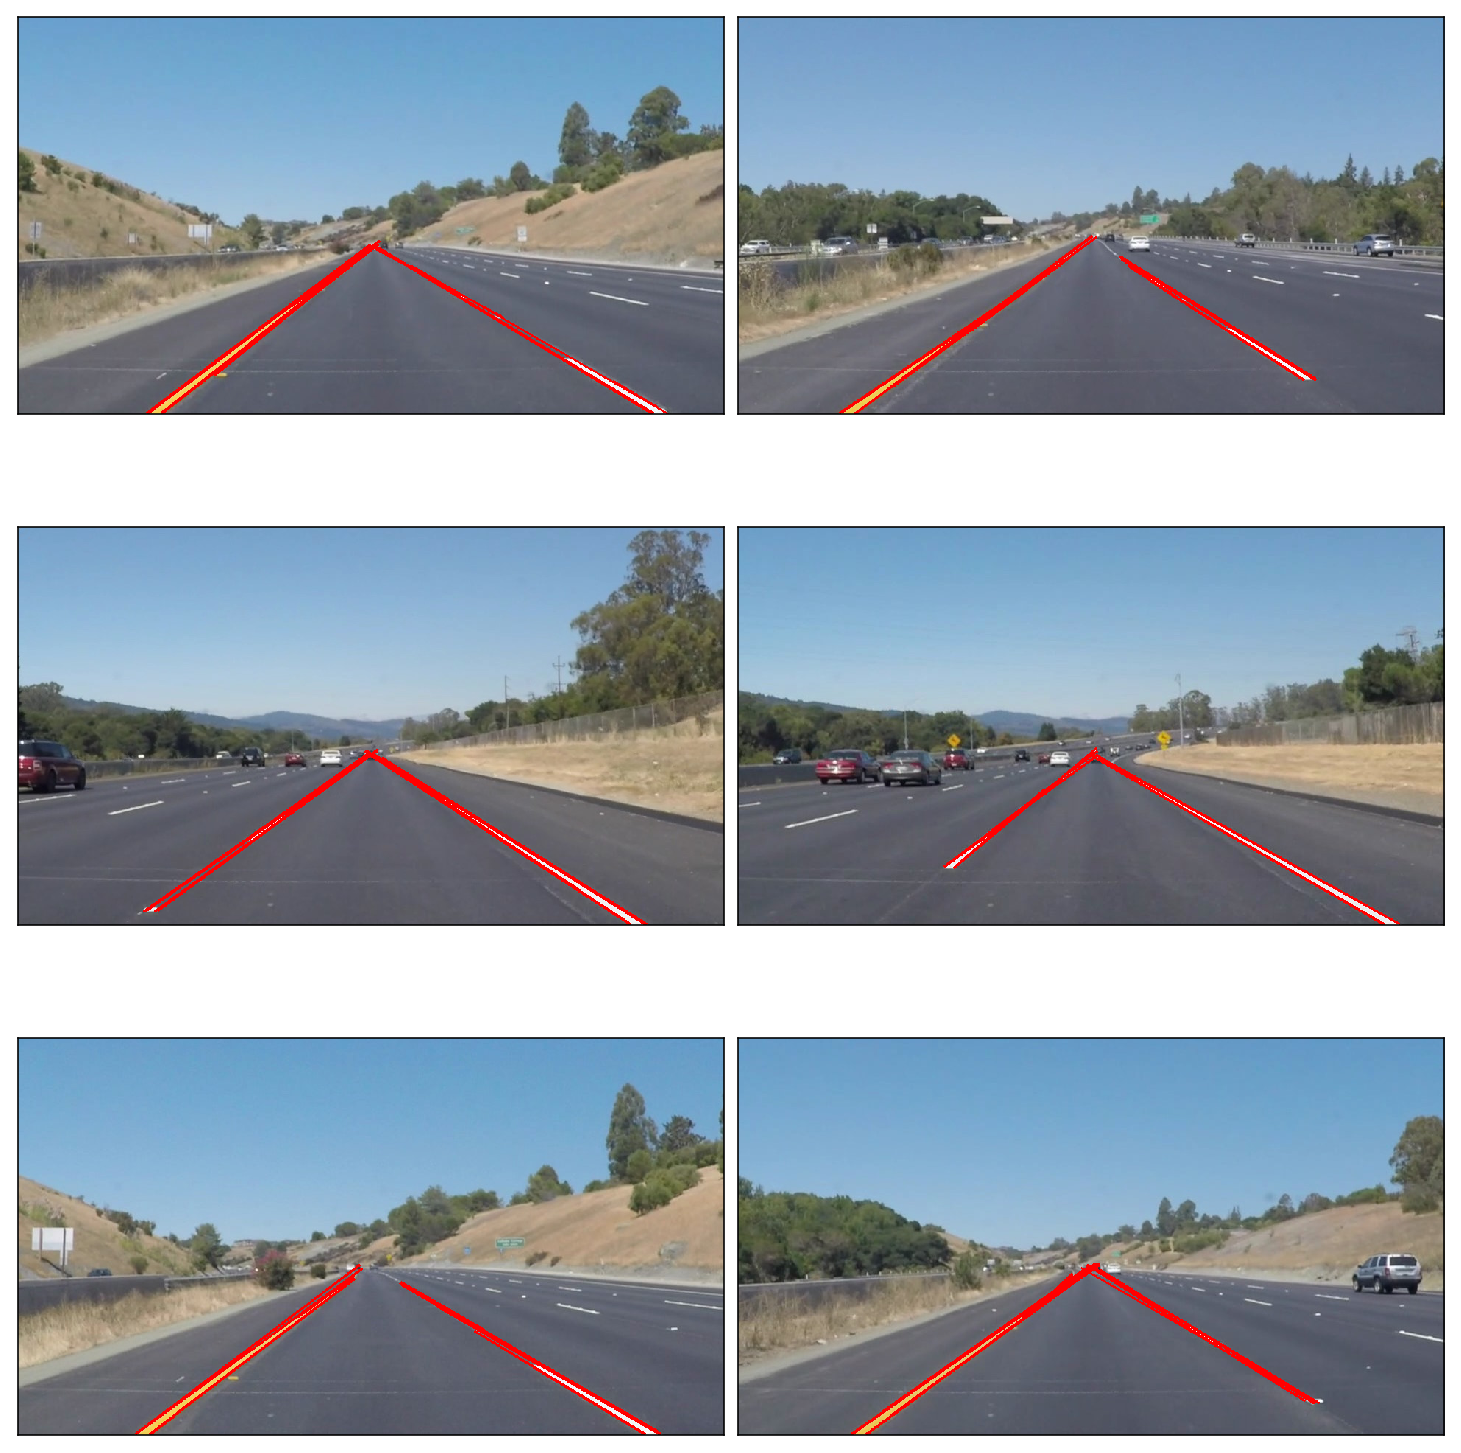

In [17]:
#os.listdir("test_images/")
TestImages = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]
LineDetection = list(map(ProcessImage,TestImages))
LineImages=[]
for Image,Lines in zip(TestImages,LineDetection):
    LineImages.append(draw_lines(Image,Lines))
ImageDisplay(LineImages)
#ImageSave(LineImages)

## Final output on Test Images with extrapolating lines
To Test on the images in the directory "test_images"  
To Draw the extrapolated left and right lane lines


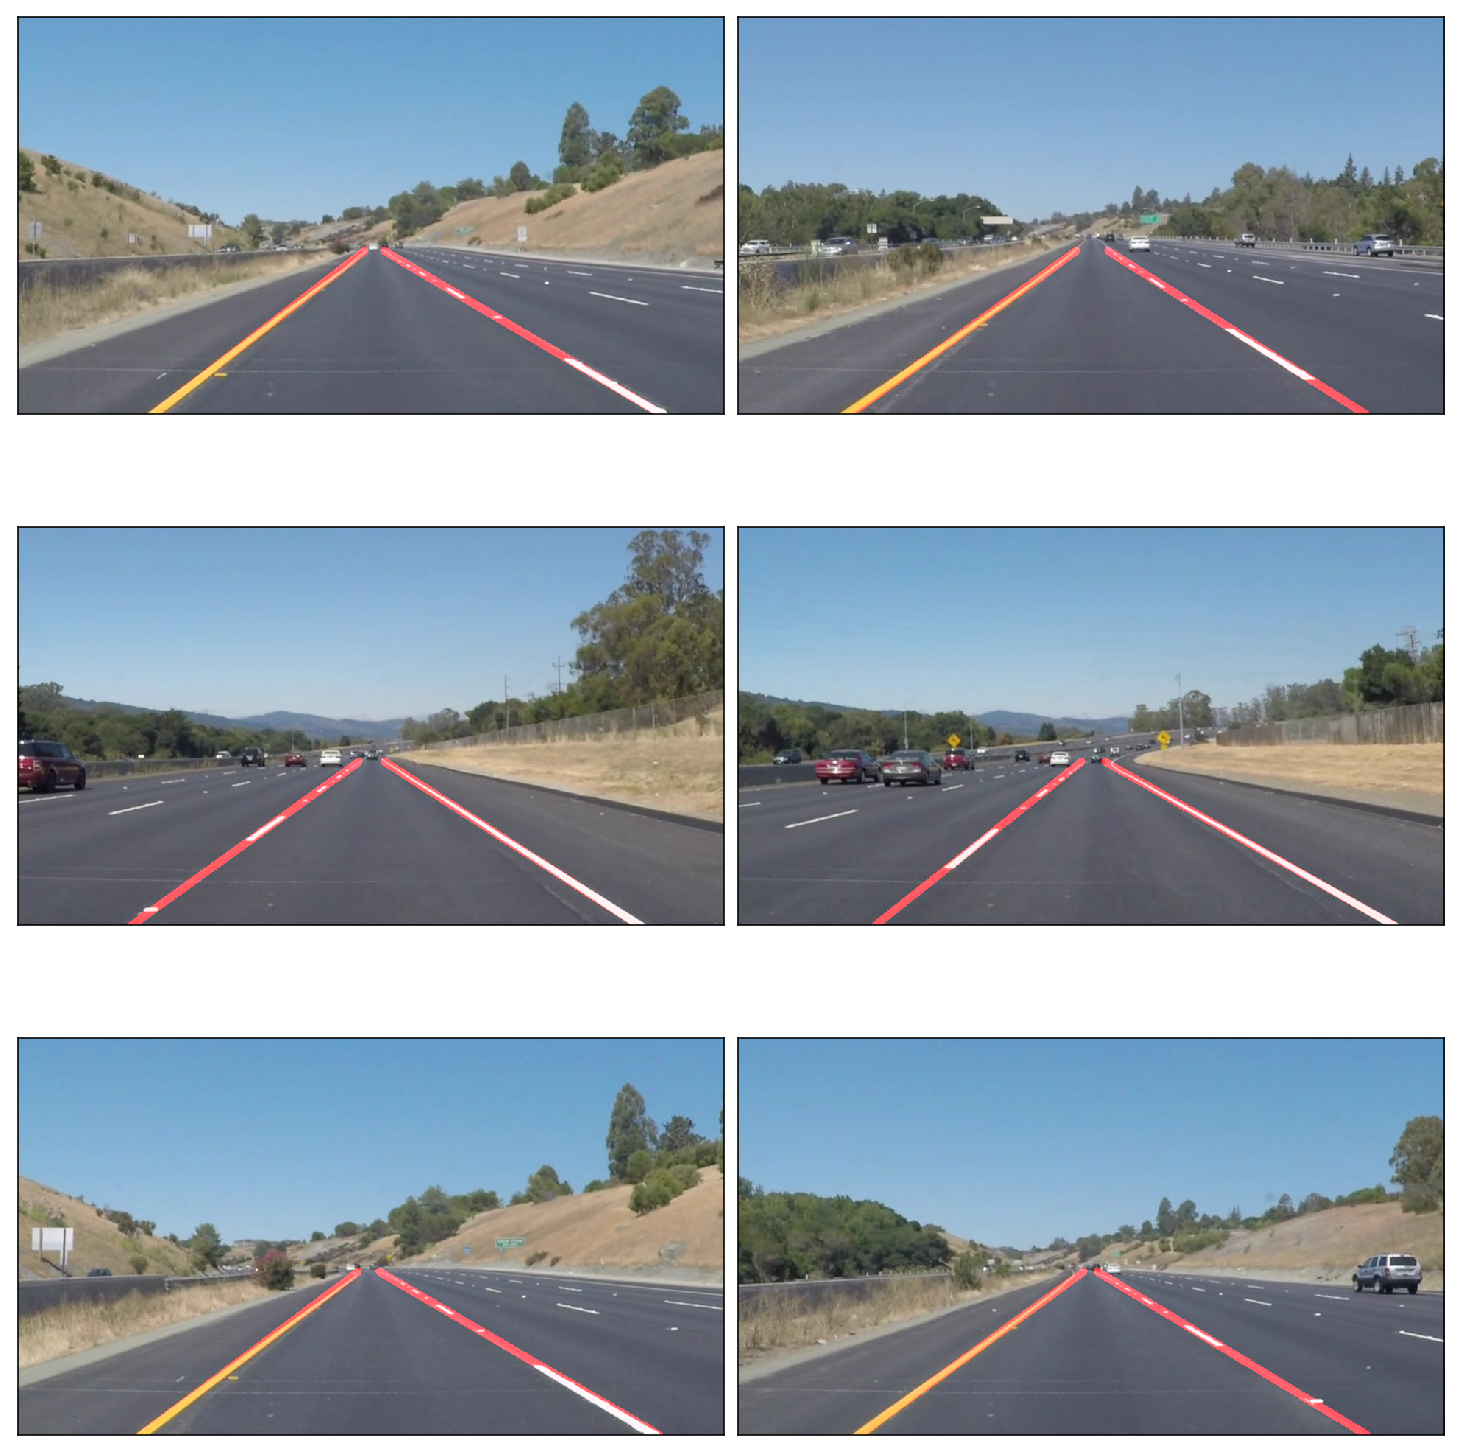

In [6]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
TestImages = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]
LineDetection = list(map(ProcessImage,TestImages))
LineImages=[]
for Image,Lines in zip(TestImages,LineDetection):
    LineImages.append(DrawLaneLines(Image,lane_lines(Image,Lines)))
ImageDisplay(LineImages)

## Saving Final Output Images
The Final output images for each scenario is dumped on the `test_images_output` folder


In [7]:
'''
multipath = "test_images/"
for file in os.listdir(multipath):
    Image = mpimg.imread(multipath+file)
    mpimg.imsave('test_images_output/'+file,DrawLaneLines(Image,lane_lines(Image,ProcessImage(Image))))
'''

'\nmultipath = "test_images/"\nfor file in os.listdir(multipath):\n    Image = mpimg.imread(multipath+file)\n    mpimg.imsave(\'test_images_output/\'+file,DrawLaneLines(Image,lane_lines(Image,ProcessImage(Image))))\n'

## Test on Videos

testing our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [8]:
QueueLength = 30

class ProcessVideo:
    '''
    Track a History of 30 frames to take mean of the left and right lane to stabilize
    the lane detection on the current frame.
    '''
    def __init__(self):
        self.left_lines = deque(maxlen=QueueLength)
        self.right_lines = deque(maxlen=QueueLength)
        
    def ProcessImage(self,Image):
        Height = np.size(Image, 0)
        Width = np.size(Image, 1)
        Diagonal = int(math.sqrt(Height**2 + Width**2))
        Apex = [Width/2,(Height/2)+Height*0.05]
        LeftBottom = [0 + Width*0.06,Height]
        RightBottom = [Width-Width*0.06,Height]
        Vertices = np.array( [LeftBottom,Apex,RightBottom], dtype=np.int32 )
        Sigma = 0.33
        KernelSize = 7
        GrayImage = grayscale(Image)
    
        BlurredImage = gaussian_blur(GrayImage,KernelSize)
        EdgeDetectedImage = canny(BlurredImage,Sigma)
        RoiMaskedImage = region_of_interest(EdgeDetectedImage,Vertices)
        rho = 1
        theta = (np.pi/180) #One Radian
        threshold = 20
        min_line_length = 20
        max_line_gap = 300
   
        #hl = hough_lines(roi,rho,theta,threshold,min_line_length,max_line_gap)
        lines = cv2.HoughLinesP(RoiMaskedImage, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
        #wei = weighted_img(hl, Image, 0.8, 1., 0.)
        #using Hough lines extract the extrapolated left and right lines
        left_line,right_line = lane_lines(Image,lines)
        
        #after taking mean of all previous 30 frames derive the left and right lanes for the current frame
        left_line = mean_line(left_line,self.left_lines)
        right_line = mean_line(right_line,self.right_lines)
        #wei = weighted_img(hl, Image, 0.8, 1., 0.)
        return DrawLaneLines(Image,(left_line,right_line))
        
        

In [9]:
VideoInputDirectory = 'test_videos/'
VideoOutputDirectory = 'test_videos_output/'
extension = '.mp4'

def VideoLoop(Input,Output):
    DetectLane = ProcessVideo()
    clip = VideoFileClip(Input)
    processed = clip.fl_image(DetectLane.ProcessImage)
    processed.write_videofile(Output,audio=False)

## Testing  on `solidWhiteRight.mp4`


In [10]:
VideoName = 'solidWhiteRight'
Input = VideoInputDirectory + VideoName + extension
Output = VideoOutputDirectory + VideoName + extension
%time VideoLoop(Input, Output)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:14<00:00, 13.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.37 s, sys: 266 ms, total: 3.64 s
Wall time: 16.9 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(Output))

## Testing on `solidYellowLeft.mp4`


In [12]:
VideoName = 'solidYellowLeft'
Input = VideoInputDirectory + VideoName + extension
Output = VideoOutputDirectory + VideoName + extension
%time VideoLoop(Input, Output)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:48<00:00, 13.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.97 s, sys: 756 ms, total: 10.7 s
Wall time: 50.7 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(Output))

In [ ]:
'''
VideoName = 'challenge'
Input = VideoInputDirectory + VideoName + extension
Output = VideoOutputDirectory + VideoName + extension
%time VideoLoop(Input, Output)
'''

In [ ]:
'''
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(Output))
'''